In [2536]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

In [2537]:
# Generates a new population
# pop_num - the size of the population
def generate_pop(pop_num):
  population = []

  for _ in range(0, pop_num):
    individual = [random.random() * 5 - 5, random.random() * 5 - 5, random.random() * 5 - 5, random.random() * 5 - 5]
    population.append(individual)

  return population

In [2538]:
def blx_alpha(x1, x2, alpha=0.5):
    c_min = min(x1, x2)
    c_max = max(x1, x2)
    I = c_max - c_min
    return random.uniform(c_min - alpha*I, c_max + alpha*I)

# crossover with 2 parents
def crossover(parent1, parent2, prob=0.7, alpha=0.5):
    # No crossover
    if random.random() > prob:
        return parent1, parent2
    
    # Generate children using BLX-alpha
    child1 = [blx_alpha(x1, x2, alpha) for x1, x2 in zip(parent1, parent2)]
    child2 = [blx_alpha(x1, x2, alpha) for x1, x2 in zip(parent1, parent2)]
    
    return child1, child2

In [2539]:
# mutation on one individual
def mutation(individual, prob=0.1):
  if (random.random() > prob):
    return individual

  random_param = random.randint(0, 3)
  individual[random_param] = random.random() * 5 if random_param == 0 else random.random() * -5

  return individual

In [2540]:
class Driver:
    def __init__(self, latitude, longitude, rest_time, x, y, z, w):
        self.latitude = latitude
        self.longitude = longitude
        self.rest_time = rest_time
        self.x = x
        self.y = y
        self.z = z
        self.w = w

class Request:
    def __init__(self, start_time, duration, distance, money, 
                 start_latitude, start_longitude, end_latitude, end_longitude):
        self.start_time = start_time
        self.duration = duration
        self.distance = distance
        self.money = money
        self.start_latitude = start_latitude
        self.start_longitude = start_longitude
        self.end_latitude = end_latitude
        self.end_longitude = end_longitude

In [2541]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points 
    on the Earth (specified in decimal degrees).
    
    Returns distance in kilometers.
    """
    R = 6371.0  # Earth's radius in km
    
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return R * c

def distance_measure(point1, point2):
  return haversine_distance(point1[0], point1[1], point2[0], point2[1])

def get_score(driver, request, density_point):
    return driver.x*request.money + driver.y*request.duration + \
    driver.z*distance_measure((driver.latitude, driver.longitude), (request.start_latitude, request.start_longitude)) + \
    driver.w*distance_measure((request.end_latitude, request.end_longitude), density_point) - \
    driver.x ** 2 - driver.y ** 2 - driver.z ** 2 - driver.w ** 2


# threshold for accepting a request
x = 10
# computes the money gained by the driver for the expected requests
def iteration(population, requests, density_point):
  money = 0
  current_time = 0
  previous_speed = None
  driver = Driver(requests[0].start_latitude, requests[0].start_longitude, 0, population[0], population[1], population[2], population[3])
  for i in range(0, len(requests)):
    if (requests[i].start_time < current_time):
      continue

    request_score = get_score(driver, requests[i], density_point)
    if (request_score > x):
      distance_to_start = distance_measure((driver.latitude, driver.longitude), (requests[i].start_latitude, requests[i].start_longitude))

      current_time = requests[i].start_time + requests[i].duration + 0 if previous_speed is None else distance_to_start / previous_speed
      driver.latitude = requests[i].end_latitude
      driver.longitude = requests[i].end_longitude
      money += requests[i].money

      previous_speed = requests[i].distance / requests[i].duration

  return money

In [2542]:
def generate_requests(request_num=20):
    data = pd.read_csv('../data/uber_hackathon_v2_mock_data.xlsx - rides_trips.csv')
    average_requests_per_day = request_num

    data = data[data['city_id'] == 1]
    data = data.sample(average_requests_per_day, random_state=1)

    avg_gap = 30
    total_span = (average_requests_per_day - 1) * avg_gap

    # Base values equally spaced
    values = np.linspace(0, total_span, average_requests_per_day)

    # Add small random noise to each gap
    noise = np.random.uniform(-15, 15, average_requests_per_day)  # tweak noise range if desired
    values = values + noise

    # Clip to [0, 600] just in case
    values = np.clip(values, 0, 600)

    # Sort to ensure increasing order
    values = np.sort(values)

    data = data[['pickup_lat', 'pickup_lon', 'drop_lat', 'drop_lon', 'distance_km', 'duration_mins', 'net_earnings']]
    data['start_time'] = values

    print(data)
    return data

def get_density_point(requests):
    average_latitude = sum(r.start_latitude for r in requests) / len(requests)
    average_longitude = sum(r.start_longitude for r in requests) / len(requests)

    return (average_latitude, average_longitude)

In [2543]:
# finds optimal parameters
# takes requests throughtout the day and number of iterations
def train(days, iter=100, pop_size=100):
  density_points = [get_density_point(days[i]) for i in range(len(days))]

  population = generate_pop(pop_size)
  best_earnings = []
  average_earnings = []

  best_one = population[0]
  best_earning = 0
  for _ in range(0, iter):
    earnings = []
    earnings_sum = 0

    for i in range(0, len(population)):
      current_earnings_sum = 0
      for j in range(len(days)):
        earning = iteration(population[i], days[j], density_points[j])
        current_earnings_sum += earning

      average_earning = current_earnings_sum / len(days)
      earnings_sum += np.exp(average_earning)
      earnings.append(average_earning)

    best_index = earnings.index(max(earnings))
    best_earnings.append(earnings[best_index])
    average_earnings.append(sum(earnings) / len(earnings))
    
    if (earnings[best_index] > best_earning):
      best_earning = earnings[best_index]
      best_one = population[best_index]

    probs = []
    for i in range(0, len(population)):
      prob = np.exp(earnings[i]) / earnings_sum
      probs.append(prob)

    new_population = []
    for i in range(0, len(population) // 2):
      parents = random.choices(population, weights=probs, k=2)

      child1, child2 = crossover(parents[0], parents[1])
      child1 = mutation(child1)
      child2 = mutation(child2)

      new_population.append(child1)
      new_population.append(child2)

    population = new_population


  plt.plot(best_earnings, label="Best Earnings", color="blue")
  plt.plot(average_earnings, label="Average Earnings", color="red")

  plt.title("Best and Average Earnings Over Generations")
  plt.xlabel("Generation")
  plt.ylabel("Earnings")
  plt.legend()  # Show legend
  plt.show()

  return best_one

      pickup_lat  pickup_lon  drop_lat  drop_lon  distance_km  duration_mins  \
5       52.36298     4.90663  52.33967   4.84363         5.22             12   
2804    52.35905     4.90111  52.36759   4.93478         5.00             31   
1874    52.34426     4.84333  52.36288   4.90440         6.56             42   
98      52.32809     4.90357  52.36398   4.93537         4.20             34   
2031    52.36073     4.90151  52.32918   4.89818         1.34             18   
1438    52.38506     4.85218  52.36630   4.93590         4.14             17   
552     52.40499     4.94658  52.38744   4.85988         4.39             31   
1093    52.40572     4.94949  52.35971   4.90095         7.68             30   
323     52.33932     4.84363  52.32611   4.90442         2.92             11   
460     52.36362     4.93103  52.34259   4.84476         4.59             39   
2033    52.38679     4.86105  52.38344   4.86175         4.17             35   
1128    52.40402     4.94605  52.32761  

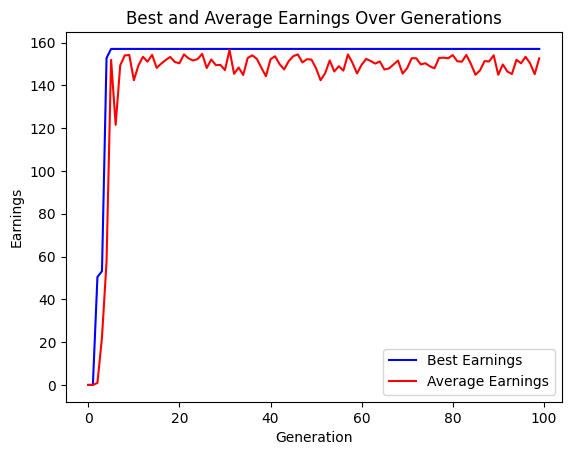

Best params:  [3.3611624807610196, -3.7155033876117387, -0.9569578117667188, 0.28770236908270164]


In [2544]:
def get_formatted_requests():
    generated_requests = generate_requests()

    requests = []
    for _, row in generated_requests.iterrows():
        req = Request(
            start_time=row['start_time'],
            duration=row['duration_mins'],
            distance=row['distance_km'],
            money=row['net_earnings'],
            start_latitude=row['pickup_lat'],
            start_longitude=row['pickup_lon'],
            end_latitude=row['drop_lat'],
            end_longitude=row['drop_lon']
        )
        requests.append(req)

    return requests

days = [get_formatted_requests() for _ in range(10)]
best_params = train(days, 100, 100)
print("Best params: ", best_params)

with open('model.json', 'w') as f:
    json.dump(best_params, f)